<a href="https://colab.research.google.com/github/christophergaughan/medical-imaging-pytorch/blob/main/03_Preprocessing_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Preprocessing: NIfTI, Orientation & Normalization

**What you'll learn:**
- How 3D medical images are stored (NIfTI format)
- The affine matrix: mapping voxels to physical space
- Orientation conventions (why your brain might be upside down)
- Resampling to different resolutions
- CT vs MRI normalization (they're fundamentally different!)

**Why this matters:**
Unlike regular images where a pixel is just a pixel, medical images exist in *physical space*.
A voxel at position `[100, 50, 30]` corresponds to an actual location in a patient's body,
measured in millimeters from some reference point. Getting this wrong means your segmentation
mask won't align with the anatomy, your measurements will be wrong, and clinicians will be unhappy.

---

## Setup & Imports

In [1]:
# For Colab: install nibabel if needed
# !pip install nibabel --quiet

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# For inline plots in Colab/Jupyter
%matplotlib inline

# Check nibabel version (should be >= 4.0 for modern features)
print(f"nibabel version: {nib.__version__}")

nibabel version: 5.3.3


## Mount Google Drive (Colab)

If you're running in Colab, mount your Drive to access the data files.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Set data path - adjust as needed
DATA_DIR = Path("/content/drive/MyDrive/AI_Medical_Images")
# DATA_DIR = Path(".")  # Use current directory if running locally

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls -la "/content/drive/MyDrive/AI_Medical_Images/"

total 69142
-rw------- 1 root root   135562 Sep 22 22:46  00-MNIST-ANN-Code-Along.ipynb
-rw------- 1 root root    23549 Sep 22 22:43  00-Tensor-Basics.ipynb
-rw------- 1 root root   100790 Sep 22 22:46  01-MNIST-with-CNN.ipynb
-rw------- 1 root root    22827 Sep 22 22:43  01-Tensor-Operations.ipynb
-rw------- 1 root root     6940 Sep 22 22:43  02-PyTorch-Basics-Exercises.ipynb
-rw------- 1 root root    10589 Sep 22 22:46  02-Using-GPU-and-CUDA.ipynb
-rw------- 1 root root  3997676 Sep 23 03:12  03-Preprocessing.ipynb
-rw------- 1 root root     8056 Sep 22 22:43  03-PyTorch-Basics-Exercises-Solutions.ipynb
drwx------ 2 root root     4096 Sep 22 22:52  04-Pneumonia-classification
drwx------ 2 root root     4096 Sep 22 22:58  05-Detection
drwx------ 2 root root     4096 Sep 22 23:00  06-Atrium-Segregation
drwx------ 2 root root     4096 Sep 22 23:08  07-LungTumor-Segmentation
drwx------ 2 root root     4096 Sep 22 23:59  08-3d-Liver-Tumor-Segmentation
-rw------- 1 root root    82496 Sep 2

---
# Part 1: The NIfTI Format

## What is NIfTI?

**NIfTI** (Neuroimaging Informatics Technology Initiative) is the standard format for 3D medical images, especially in research. It replaced the older ANALYZE format.

A `.nii` or `.nii.gz` file contains:
1. **Header**: Metadata (dimensions, voxel size, orientation, data type)
2. **Data**: The actual 3D (or 4D for fMRI) voxel intensities

**Key insight**: Unlike a JPEG where pixels are just RGB values, NIfTI knows *where in physical space* each voxel lives.

---

We'll use a T1-weighted brain MRI from the [IXI Dataset](https://brain-development.org/ixi-dataset/) (CC BY-SA 3.0).

In [8]:
# Load the brain MRI
brain_mri = nib.load(DATA_DIR / "IXI662-Guys-1120-T1.nii.gz")

# The NIfTI object is lazy - data isn't loaded until you ask for it
print(f"Type: {type(brain_mri)}")
print(f"Shape: {brain_mri.shape}")
print(f"Data type: {brain_mri.get_data_dtype()}")

Type: <class 'nibabel.nifti1.Nifti1Image'>
Shape: (256, 256, 150)
Data type: int16


In [9]:
# Extract the actual voxel data as a numpy array
# get_fdata() returns float64 by default (safe for computation)
brain_data = brain_mri.get_fdata()

print(f"Array shape: {brain_data.shape}")
print(f"Array dtype: {brain_data.dtype}")
print(f"Value range: [{brain_data.min():.1f}, {brain_data.max():.1f}]")
print(f"Memory: {brain_data.nbytes / 1e6:.1f} MB")

Array shape: (256, 256, 150)
Array dtype: float64
Value range: [0.0, 1055.0]
Memory: 78.6 MB


### Quick Sanity Check: Visualize a Slice

Before diving into the math, let's make sure we loaded something that looks like a brain.

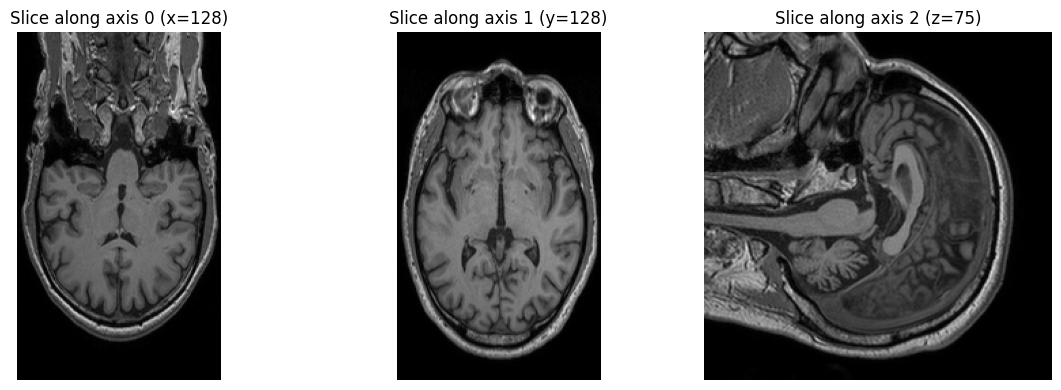

In [10]:
# Grab a slice from the middle of each axis
mid_x, mid_y, mid_z = [s // 2 for s in brain_data.shape]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(brain_data[mid_x, :, :], cmap='gray')
axes[0].set_title(f'Slice along axis 0 (x={mid_x})')

axes[1].imshow(brain_data[:, mid_y, :], cmap='gray')
axes[1].set_title(f'Slice along axis 1 (y={mid_y})')

axes[2].imshow(brain_data[:, :, mid_z], cmap='gray')
axes[2].set_title(f'Slice along axis 2 (z={mid_z})')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Wait, why does the brain look rotated/upside down?**

This is where orientation comes in. The array axes don't necessarily correspond to the anatomical axes you'd expect (left-right, front-back, top-bottom). Let's fix that understanding.

---

# Part 2: The Affine Matrix (The Key to Everything)

## What Problem Does It Solve?

You have a 3D array with indices `[i, j, k]`. But:
- What **physical location** (in mm) does voxel `[100, 50, 30]` correspond to?
- How big is each voxel? (1mm? 0.5mm? Different in each direction?)
- Which direction is "up"? Which is "left"?

The **affine matrix** answers all of these.

## The 4×4 Affine Matrix

$$
\begin{pmatrix}
x \\ y \\ z \\ 1
\end{pmatrix}
=
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
i \\ j \\ k \\ 1
\end{pmatrix}
$$

Where:
- `[i, j, k]` = voxel indices (what you use to index the numpy array)
- `[x, y, z]` = physical coordinates in mm (scanner/world space)
- The **3×3 submatrix** handles rotation, scaling, and shearing
- The **translation vector** `[tx, ty, tz]` is the offset (where voxel [0,0,0] sits in physical space)
- The bottom row `[0, 0, 0, 1]` is for mathematical convenience (homogeneous coordinates)

**Pro tip**: The 4×4 structure lets you chain transformations via matrix multiplication.

In [11]:
# Get the affine matrix
affine = brain_mri.affine

print("Affine matrix:")
print(affine)
print(f"\nShape: {affine.shape}")

Affine matrix:
[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Shape: (4, 4)


In [12]:
# Let's break it down:

# The 3x3 rotation/scale submatrix
rotation_scale = affine[:3, :3]
print("Rotation/Scale submatrix:")
print(rotation_scale)

# The translation vector (offset)
translation = affine[:3, 3]
print(f"\nTranslation (offset): {translation}")
print("This is where voxel [0,0,0] sits in physical space (mm)")

Rotation/Scale submatrix:
[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11]]

Translation (offset): [ -90.67985535  102.82944489 -114.82378387]
This is where voxel [0,0,0] sits in physical space (mm)


### Voxel Size (Spacing)

The voxel dimensions are encoded in the affine matrix, but nibabel gives us a convenient accessor:

In [13]:
voxel_size = brain_mri.header.get_zooms()
print(f"Voxel size: {voxel_size} mm")
print(f"  - X direction: {voxel_size[0]:.4f} mm")
print(f"  - Y direction: {voxel_size[1]:.4f} mm")
print(f"  - Z direction: {voxel_size[2]:.4f} mm")

# Note: These aren't always equal! Anisotropic voxels are common.
# This MRI has ~0.94mm in-plane resolution but 1.2mm slice thickness.

Voxel size: (np.float32(0.9375), np.float32(0.9375), np.float32(1.2000039)) mm
  - X direction: 0.9375 mm
  - Y direction: 0.9375 mm
  - Z direction: 1.2000 mm


### Converting Between Voxel and Physical Coordinates

This is a bread-and-butter operation. You'll need it when:
- Registering scans from different sessions/patients
- Mapping atlas coordinates to a specific patient
- Reporting tumor locations to clinicians (they think in mm, not voxels)

In [14]:
# Voxel → Physical: Just multiply by the affine
# We append a 1 for homogeneous coordinates

voxel_coord = np.array([100, 128, 75])  # Some voxel in the brain
voxel_homogeneous = np.append(voxel_coord, 1)  # [100, 128, 75, 1]

physical_coord = affine @ voxel_homogeneous  # Matrix multiplication

print(f"Voxel coordinate: {voxel_coord}")
print(f"Physical coordinate: {physical_coord[:3]} mm")

Voxel coordinate: [100 128  75]
Physical coordinate: [ 0.85156795 28.91046937 17.26368487] mm


In [15]:
# Physical → Voxel: Use the inverse affine

affine_inv = np.linalg.inv(affine)

# Let's convert back and verify we get our original voxel
recovered_voxel = affine_inv @ physical_coord

print(f"Original voxel: {voxel_coord}")
print(f"Recovered voxel: {recovered_voxel[:3].round().astype(int)}")
print("✓ Round trip successful!" if np.allclose(voxel_coord, recovered_voxel[:3]) else "✗ Something's wrong")

Original voxel: [100 128  75]
Recovered voxel: [100 128  75]
✓ Round trip successful!


### Modern nibabel: Cleaner Coordinate Transforms

nibabel provides utility functions so you don't have to manually handle homogeneous coordinates:

In [16]:
from nibabel.affines import apply_affine

# Single point
physical = apply_affine(affine, voxel_coord)
print(f"Voxel {voxel_coord} → Physical {physical.round(2)} mm")

# Works with arrays of points too
voxel_coords = np.array([
    [0, 0, 0],
    [128, 128, 75],
    [255, 255, 149]
])
physical_coords = apply_affine(affine, voxel_coords)
print("\nMultiple points:")
for v, p in zip(voxel_coords, physical_coords):
    print(f"  {v} → {p.round(2)} mm")

Voxel [100 128  75] → Physical [ 0.85 28.91 17.26] mm

Multiple points:
  [0 0 0] → [ -90.68  102.83 -114.82] mm
  [128 128  75] → [ 1.38  2.93 20.99] mm
  [255 255 149] → [ 92.23 -96.2  155.74] mm


---
# Part 3: Orientation (Why That Brain Image Looks Weird)

## The Problem

Different scanners, hospitals, and software save images in different orientations. Your array's axes might be:
- `[anterior→posterior, inferior→superior, left→right]`
- `[right→left, anterior→posterior, inferior→superior]`
- Or any of 48 possible permutations!

## Anatomical Directions

| Letter | Direction | Meaning |
|--------|-----------|--------|
| **R** | Right | Patient's right side |
| **L** | Left | Patient's left side |
| **A** | Anterior | Front (nose side) |
| **P** | Posterior | Back (spine side) |
| **S** | Superior | Top (head) |
| **I** | Inferior | Bottom (feet) |

## Reading Orientation Codes

`nib.aff2axcodes()` tells you which anatomical direction each array axis *ends at*.

For example, `('P', 'S', 'R')` means:
- Axis 0: goes from Anterior → **P**osterior (front to back)
- Axis 1: goes from Inferior → **S**uperior (bottom to top)  
- Axis 2: goes from Left → **R**ight

In [17]:
orientation = nib.aff2axcodes(affine)
print(f"Orientation codes: {orientation}")

# Decode it
axis_meanings = {
    'R': 'Left → Right',
    'L': 'Right → Left',
    'A': 'Posterior → Anterior',
    'P': 'Anterior → Posterior',
    'S': 'Inferior → Superior',
    'I': 'Superior → Inferior'
}

print("\nThis means:")
for i, code in enumerate(orientation):
    print(f"  Axis {i}: {axis_meanings[code]}")

Orientation codes: ('P', 'S', 'R')

This means:
  Axis 0: Anterior → Posterior
  Axis 1: Inferior → Superior
  Axis 2: Left → Right


### Visualizing Each Anatomical View

Now that we understand the orientation, let's slice through each anatomical plane:

- **Axial** (transverse): Slicing top-to-bottom, looking down at the head
- **Coronal**: Slicing front-to-back, looking at the face
- **Sagittal**: Slicing left-to-right, looking at the side of the head

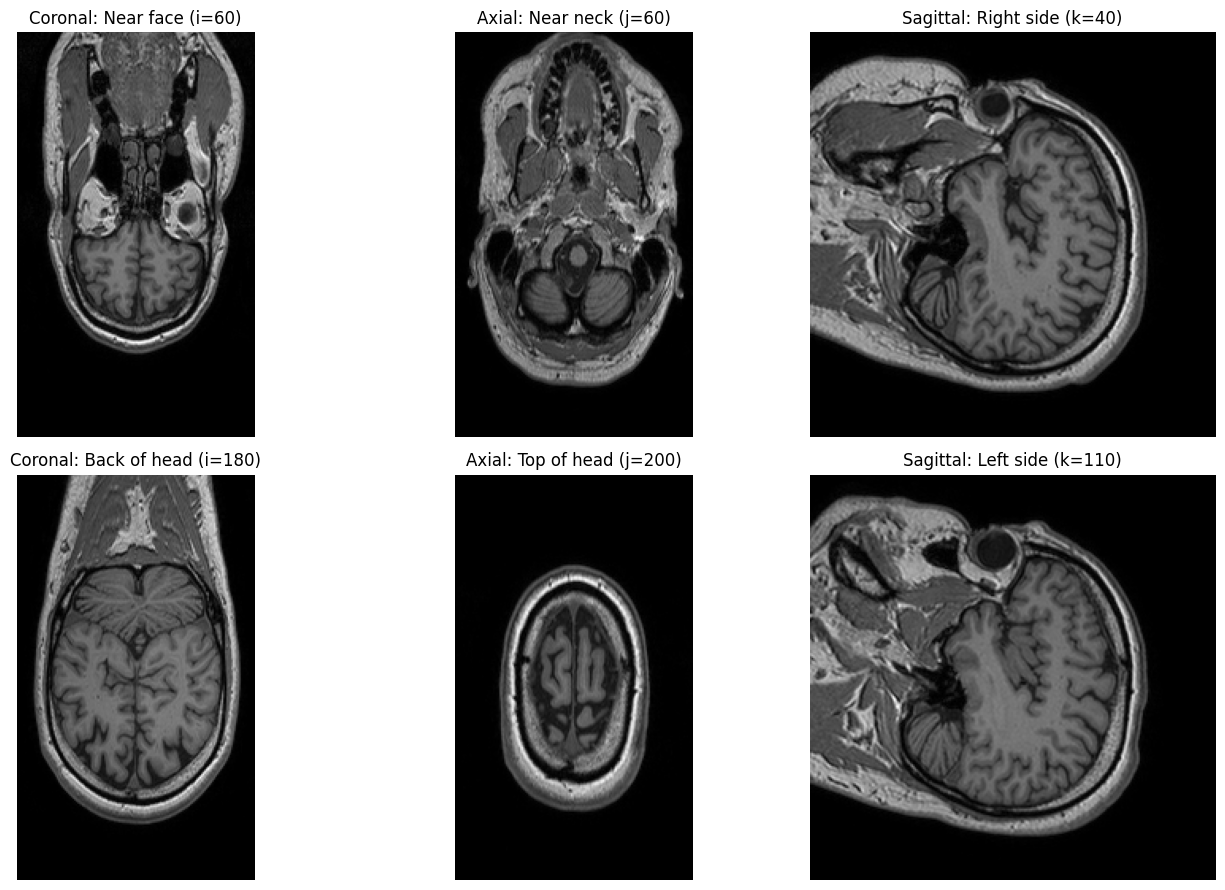

In [18]:
# Based on orientation ('P', 'S', 'R'):
# - Axis 0 slices CORONAL (front to back)
# - Axis 1 slices AXIAL (bottom to top)
# - Axis 2 slices SAGITTAL (left to right)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Coronal views (slicing axis 0)
axes[0, 0].imshow(brain_data[60, :, :], cmap='gray')
axes[0, 0].set_title('Coronal: Near face (i=60)')
axes[1, 0].imshow(brain_data[180, :, :], cmap='gray')
axes[1, 0].set_title('Coronal: Back of head (i=180)')

# Axial views (slicing axis 1)
axes[0, 1].imshow(brain_data[:, 60, :], cmap='gray')
axes[0, 1].set_title('Axial: Near neck (j=60)')
axes[1, 1].imshow(brain_data[:, 200, :], cmap='gray')
axes[1, 1].set_title('Axial: Top of head (j=200)')

# Sagittal views (slicing axis 2)
axes[0, 2].imshow(brain_data[:, :, 40], cmap='gray')
axes[0, 2].set_title('Sagittal: Right side (k=40)')
axes[1, 2].imshow(brain_data[:, :, 110], cmap='gray')
axes[1, 2].set_title('Sagittal: Left side (k=110)')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Reorienting to Canonical (RAS+)

**RAS+** (Right-Anterior-Superior) is a common standard orientation:
- Axis 0: Left → Right
- Axis 1: Posterior → Anterior  
- Axis 2: Inferior → Superior

nibabel can reorient your data to this canonical form:

In [19]:
# Reorient to RAS+ (canonical)
brain_mri_canonical = nib.as_closest_canonical(brain_mri)
brain_canonical_data = brain_mri_canonical.get_fdata()

print(f"Original orientation: {nib.aff2axcodes(brain_mri.affine)}")
print(f"Canonical orientation: {nib.aff2axcodes(brain_mri_canonical.affine)}")
print(f"\nOriginal shape: {brain_mri.shape}")
print(f"Canonical shape: {brain_mri_canonical.shape}")

Original orientation: ('P', 'S', 'R')
Canonical orientation: ('R', 'A', 'S')

Original shape: (256, 256, 150)
Canonical shape: (150, 256, 256)


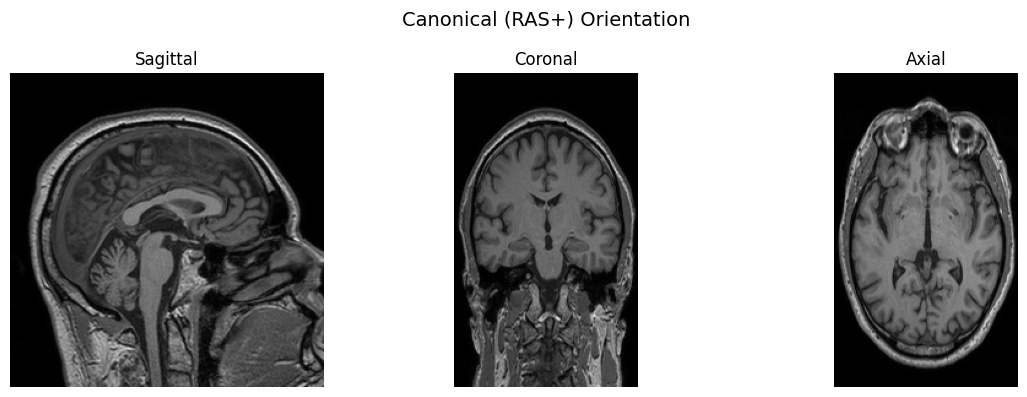

In [20]:
# Now the slices should be in the "expected" orientations
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

mid = [s // 2 for s in brain_canonical_data.shape]

# In RAS+:
# Axis 0 → Sagittal (L-R)
# Axis 1 → Coronal (P-A)
# Axis 2 → Axial (I-S)

axes[0].imshow(np.rot90(brain_canonical_data[mid[0], :, :]), cmap='gray')
axes[0].set_title('Sagittal')

axes[1].imshow(np.rot90(brain_canonical_data[:, mid[1], :]), cmap='gray')
axes[1].set_title('Coronal')

axes[2].imshow(np.rot90(brain_canonical_data[:, :, mid[2]]), cmap='gray')
axes[2].set_title('Axial')

for ax in axes:
    ax.axis('off')

plt.suptitle('Canonical (RAS+) Orientation', fontsize=14)
plt.tight_layout()
plt.show()

---
# Part 4: Resampling (Changing Resolution)

## Why Resample?

1. **Memory constraints**: A 512×512×500 volume might not fit in GPU memory
2. **Standardization**: Different scanners produce different resolutions; you want consistent input to your model
3. **Isotropic voxels**: Many algorithms assume cubic voxels; resampling can fix anisotropic data

## The Tradeoff

Downsampling loses information. A 0.5mm tumor might disappear if you resample to 2mm voxels. Always consider your clinical requirements.

In [21]:
print(f"Original shape: {brain_mri.shape}")
print(f"Original voxel size: {brain_mri.header.get_zooms()} mm")

# Calculate physical dimensions
physical_dims = np.array(brain_mri.shape) * np.array(brain_mri.header.get_zooms())
print(f"Physical dimensions: {physical_dims.round(1)} mm")

Original shape: (256, 256, 150)
Original voxel size: (np.float32(0.9375), np.float32(0.9375), np.float32(1.2000039)) mm
Physical dimensions: [240. 240. 180.] mm


In [22]:
import nibabel.processing

# Resample to 2mm isotropic voxels, smaller volume
new_voxel_size = (2.0, 2.0, 2.0)  # mm
new_shape = (128, 128, 100)

brain_mri_resampled = nibabel.processing.conform(
    brain_mri,
    out_shape=new_shape,
    voxel_size=new_voxel_size,
    orientation='PSR'  # Keep original orientation
)

brain_resampled_data = brain_mri_resampled.get_fdata()

print(f"Resampled shape: {brain_mri_resampled.shape}")
print(f"Resampled voxel size: {brain_mri_resampled.header.get_zooms()} mm")
print(f"\nMemory reduction: {brain_data.nbytes / brain_resampled_data.nbytes:.1f}x")

Resampled shape: (128, 128, 100)
Resampled voxel size: (np.float32(2.0), np.float32(2.0), np.float32(2.0)) mm

Memory reduction: 6.0x


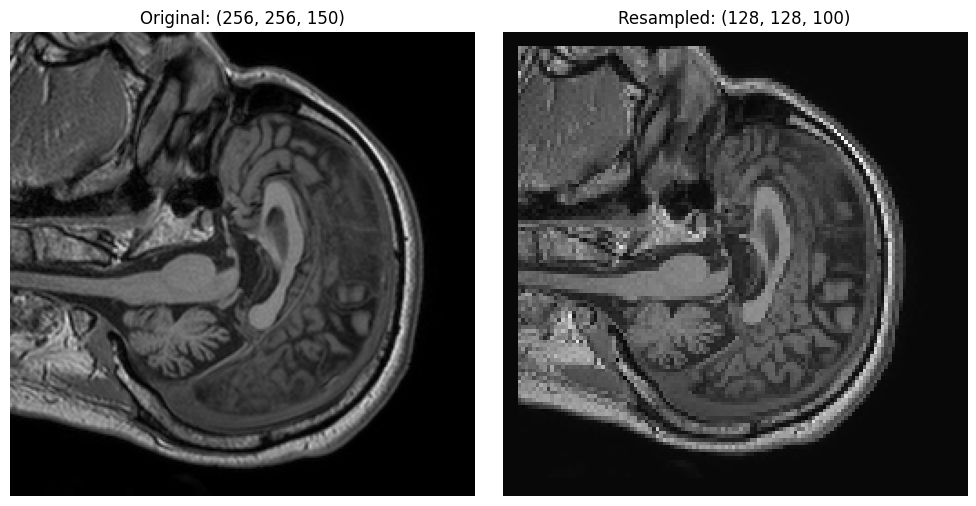

In [23]:
# Compare original vs resampled
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pick corresponding slices (accounting for different sizes)
orig_slice = brain_data[:, :, 75]
resamp_slice = brain_resampled_data[:, :, 50]  # ~75 * (100/150)

axes[0].imshow(orig_slice, cmap='gray')
axes[0].set_title(f'Original: {brain_data.shape}')

axes[1].imshow(resamp_slice, cmap='gray')
axes[1].set_title(f'Resampled: {brain_resampled_data.shape}')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

---
# Part 5: Normalization (CT vs MRI - They're Different!)

This is a **crucial distinction** that trips up many newcomers to medical imaging.

## CT: Absolute Scale (Hounsfield Units)

CT scanners measure X-ray attenuation on a **standardized scale**:

| Material | Hounsfield Units (HU) |
|----------|----------------------|
| Air | -1000 |
| Lung | -500 |
| Fat | -100 to -50 |
| Water | 0 |
| Soft tissue | +40 to +80 |
| Bone | +700 to +3000 |

**Key point**: A value of 0 HU means the same thing in every CT scan ever taken. This is physics-based, not arbitrary.

## MRI: Relative Scale (Arbitrary Units)

MRI signal intensity depends on:
- Scanner manufacturer and model
- Magnetic field strength (1.5T vs 3T)
- Pulse sequence parameters
- Coil used
- Patient positioning

**Key point**: A value of 500 in one MRI tells you nothing about what 500 means in another MRI, even of the same patient on the same scanner.

---

## CT Normalization: Simple Scaling

Since CT has a fixed range, you can just divide by the max expected value:

In [24]:
# Load a lung CT from the Medical Segmentation Decathlon
# (http://medicaldecathlon.com/, CC BY-SA 4.0)

lung_ct = nib.load(DATA_DIR / "lung_043.nii.gz")
lung_ct_data = lung_ct.get_fdata()

print(f"Shape: {lung_ct_data.shape}")
print(f"Value range: [{lung_ct_data.min():.0f}, {lung_ct_data.max():.0f}] HU")

Shape: (512, 512, 129)
Value range: [-1024, 1954] HU


In [25]:
# Simple standardization: divide by max expected value
# Practical range is about -1024 to 3071
CT_MAX = 3071

lung_ct_standardized = lung_ct_data / CT_MAX

print(f"Standardized range: [{lung_ct_standardized.min():.3f}, {lung_ct_standardized.max():.3f}]")

Standardized range: [-0.333, 0.636]


## CT Windowing: Task-Specific Contrast

Radiologists use "windows" to visualize different tissues. This is essentially clipping the HU range to emphasize certain structures.

| Window | HU Range | Use Case |
|--------|----------|----------|
| Lung | -1000 to -500 | Pulmonary vessels, nodules |
| Soft tissue | -250 to +250 | Organs, masses |
| Bone | -500 to +1500 | Skeletal structures |
| Brain | 0 to +80 | Intracranial structures |

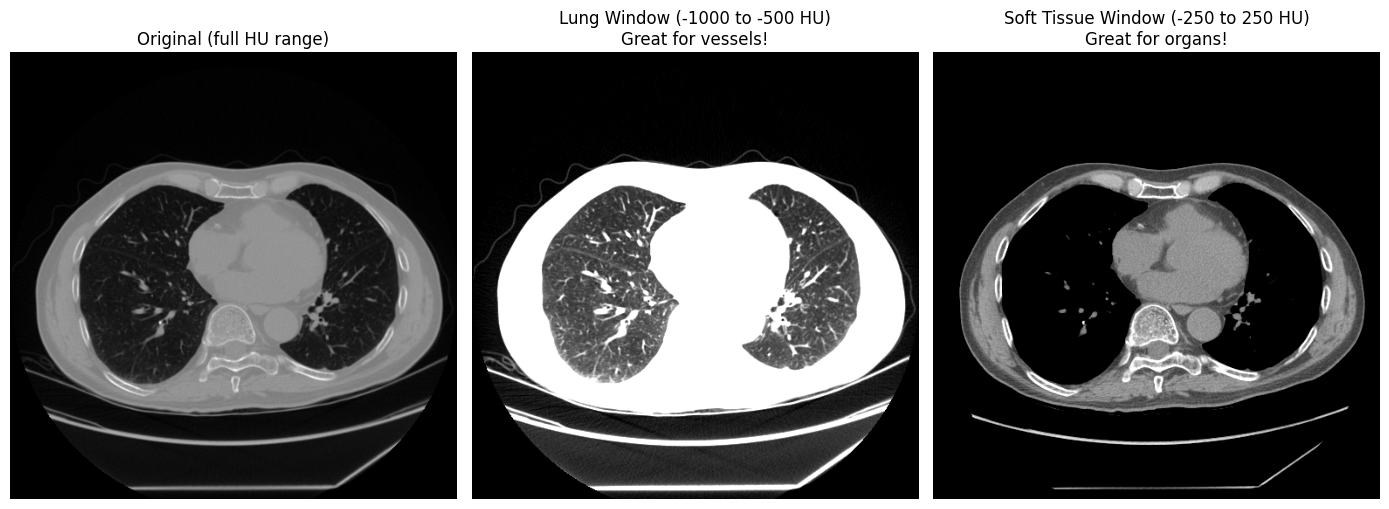

In [26]:
def apply_window(volume: np.ndarray, window_min: float, window_max: float) -> np.ndarray:
    """Apply a HU window and normalize to [0, 1]."""
    windowed = np.clip(volume, window_min, window_max)
    normalized = (windowed - window_min) / (window_max - window_min)
    return normalized

# Apply different windows
lung_window = apply_window(lung_ct_data, -1000, -500)
soft_tissue_window = apply_window(lung_ct_data, -250, 250)

# Visualize
slice_idx = 50

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(np.rot90(lung_ct_data[:, :, slice_idx]), cmap='gray')
axes[0].set_title('Original (full HU range)')

axes[1].imshow(np.rot90(lung_window[:, :, slice_idx]), cmap='gray')
axes[1].set_title('Lung Window (-1000 to -500 HU)\nGreat for vessels!')

axes[2].imshow(np.rot90(soft_tissue_window[:, :, slice_idx]), cmap='gray')
axes[2].set_title('Soft Tissue Window (-250 to 250 HU)\nGreat for organs!')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Notice how the lung window shows incredible detail in the pulmonary vasculature, but the abdomen is completely washed out. The soft tissue window shows organs clearly but the lung looks like a black void.**

For deep learning, you often need to choose the appropriate window for your task, or use multiple windows as different input channels.

---

## MRI Normalization: Per-Patient Z-Score + Min-Max

Since MRI values are arbitrary, we normalize each scan individually:

1. **Z-score normalization**: Subtract mean, divide by std → zero mean, unit variance
$$X_{\text{zscore}} = \frac{X - \mu}{\sigma}$$

2. **Min-max scaling**: Rescale to [0, 1] range
$$X_{\text{scaled}} = \frac{X - \min(X)}{\max(X) - \min(X)}$$

Often you do both: z-score first (to handle outliers), then min-max (to get bounded range for neural networks).

In [27]:
# Load cardiac MRI from Medical Segmentation Decathlon
cardiac_mri = nib.load(DATA_DIR / "la_003.nii.gz")
cardiac_mri_data = cardiac_mri.get_fdata()

print(f"Shape: {cardiac_mri_data.shape}")
print(f"Raw value range: [{cardiac_mri_data.min():.1f}, {cardiac_mri_data.max():.1f}]")
print(f"Mean: {cardiac_mri_data.mean():.1f}, Std: {cardiac_mri_data.std():.1f}")

Shape: (320, 320, 130)
Raw value range: [0.0, 1999.0]
Mean: 172.7, Std: 263.3


In [28]:
def normalize_mri(volume: np.ndarray) -> np.ndarray:
    """Z-score normalize then min-max scale an MRI volume."""
    # Z-score normalization
    mean = np.mean(volume)
    std = np.std(volume)
    z_normalized = (volume - mean) / std

    # Min-max scaling to [0, 1]
    min_val = np.min(z_normalized)
    max_val = np.max(z_normalized)
    scaled = (z_normalized - min_val) / (max_val - min_val)

    return scaled

cardiac_normalized = normalize_mri(cardiac_mri_data)

print(f"Normalized range: [{cardiac_normalized.min():.3f}, {cardiac_normalized.max():.3f}]")
print(f"Normalized mean: {cardiac_normalized.mean():.3f}")

Normalized range: [0.000, 1.000]
Normalized mean: 0.086


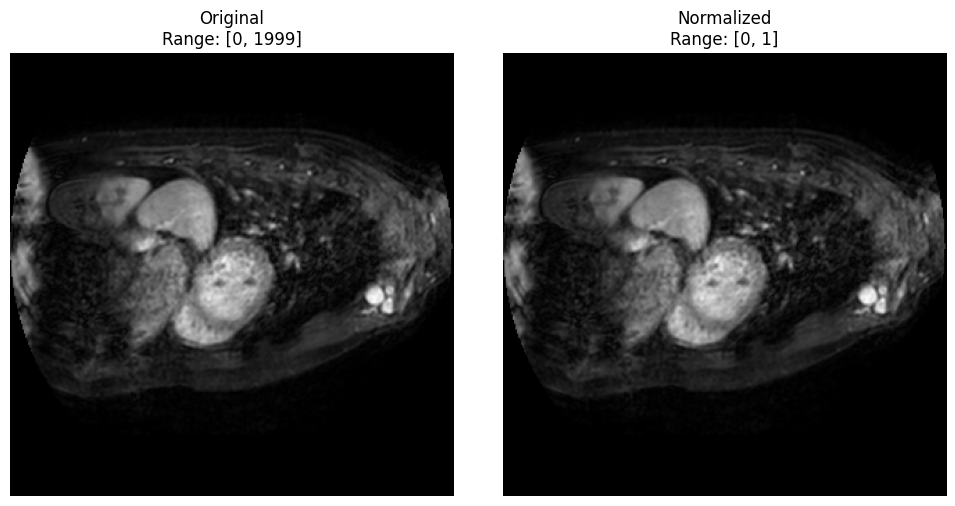

In [29]:
# Visualize
slice_idx = 30

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cardiac_mri_data[:, :, slice_idx], cmap='gray')
axes[0].set_title(f'Original\nRange: [{cardiac_mri_data.min():.0f}, {cardiac_mri_data.max():.0f}]')

axes[1].imshow(cardiac_normalized[:, :, slice_idx], cmap='gray')
axes[1].set_title(f'Normalized\nRange: [0, 1]')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

---
# Summary: Key Takeaways

## NIfTI Format
- Standard for 3D medical images
- Contains both voxel data AND spatial metadata
- Use `nibabel` to load: `nib.load()` → `.get_fdata()` for numpy array

## Affine Matrix
- 4×4 matrix mapping voxel coordinates → physical coordinates (mm)
- `affine @ [i, j, k, 1]` = `[x, y, z, 1]` in mm
- Encodes: rotation, scaling, translation, and orientation

## Orientation
- `nib.aff2axcodes(affine)` tells you anatomical axis directions
- RAS+ is a common standard; use `nib.as_closest_canonical()` to convert
- **Always check orientation** when loading new data!

## Resampling
- Use `nibabel.processing.conform()` to resize volumes
- Remember to adjust voxel size accordingly
- Tradeoff: memory/speed vs. spatial resolution

## Normalization

| Modality | Scale Type | Normalization |
|----------|-----------|---------------|
| **CT** | Absolute (HU) | Divide by max, or apply task-specific window |
| **MRI** | Arbitrary | Z-score per patient, then min-max scale |

---

## Next Steps

- **04-Pneumonia-Classification**: Apply these concepts to X-ray (2D) data
- **06-Atrium-Segmentation**: Build a U-Net using 3D cardiac MRI
- **For your Cole meeting**: You now speak the language of NIfTI, affines, and MRI preprocessing!

---
## Bonus: Modern Alternatives

For production pipelines, consider:

- **[TorchIO](https://torchio.readthedocs.io/)**: PyTorch-native medical image transforms
- **[MONAI](https://monai.io/)**: Medical imaging framework from NVIDIA + academic partners
- **[SimpleITK](https://simpleitk.org/)**: More comprehensive than nibabel, especially for registration

But nibabel remains the go-to for basic NIfTI I/O.

In [30]:
# Optional: Check if these are installed
# !pip install torchio monai SimpleITK --quiet